# Homework #02: Tree

**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2025q2_<фамилия>_HW02.ipynb`` (пример ``ml_b2c2025q2_dral_HW02.ipynb``)
- Открыть форму сдачи ДЗ:[ML-B2C-2025-Q2](https://www.google.com/url?q=https%3A%2F%2Fforms.gle%2F1cS6HPGgvdSzPfuc9)
- Выбрать задание HW02: ML Tree
- Указать ваш логин на образовательной платформе (логин EDX)
- Загрузить файл с решением`

**Дополнительные ссылки**
- Настройка локального окружения: https://github.com/big-data-team/ml-course
- Датасеты UCI: https://archive.ics.uci.edu/
- BDT Streamlit Demo обучения kNN: https://bdt-knn-demo.streamlit.app/

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

    https://forms.gle/GnuG1EpcgQd1wRdV7
   

# Вопросы на понимание
1. Какие преимущества и недостатки имеют деревья решений?
2. Какие критерии разбиения используются при построении деревьев для решения задач классификации и регрессии?
3. С помощью каких параметров возможно обеспечить контроль переобучения?
4. Регрессионое дерево при прогнозе выдает случайный объект попавший в лист или среднее всех объектов в листе? Свой ответ поясните.
5. При решении задачи бинарной классификации дерево «выбирает» лучшее разбиение из двух вариантов:  
Первое разбиение: [10; 30] и [20; 40] (цифры показывают количество объектов в каждом классе).  
Второе разбиение:  [20; 10] и [10; 60]  
Посчитайте прирост информации c помощью энтропийного критерия. Какое разбиение лучше?
6. Давайте рассмотрим туже задачу , но для четырех классов:   
Первое разбиение: [0; 30; 40; 50] и [40; 25; 45; 45]  
Второе разбиение:  [20; 10; 40;10] и [20; 45; 45; 85]  





# Полезные import'ы и вспомогательные функции

In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
# функция для формирования csv-файла для посылки на kaggle
def save_submission(predictions, test_idx, fout="titanic_first_submission.csv"):
    submission = pd.DataFrame({"PassengerId":test_idx, "Survived":predictions})
    submission.to_csv(fout, index=False)

## 1. Чтение и предобработка данных (20%)

Будем работать с данными соревнования на kaggle https://www.kaggle.com/c/titanic/data. Задача - предсказать выживет пассажир или нет. Описание данных доступно по ссылке.

In [5]:
# https://www.kaggle.com/c/titanic/data description
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Зафиксируем целевую переменную и удалим ее из данных.

In [6]:
y = train_df['Survived']
train_df.drop('Survived', axis=1, inplace=True)

Посмотрим на основные характеристики признаков.

In [7]:
train_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [8]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Peter, Master. Michael J",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


Удалим признаки `PassengerId`, `Name`, `Ticket` и `Cabin` из данных.

In [9]:
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


В обучающей выборке есть пропуски в признаках `Age` и `Embarked`, в тестовой - в `Age` и `Fare`.

Заполните пропуски в признаке `Age` обучающей и тестовой выборок медианным значением. Вспомните, как заполнялись пропуски в тестовых данных на занятии в задаче скоринга.

In [12]:
age_median = train_df['Age'].median()
train_df['Age'].fillna(age_median, inplace=True)
test_df['Age'].fillna(age_median, inplace=True)

C:\Users\Bakhyt\AppData\Local\Temp\ipykernel_17508\1919165849.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(age_median, inplace=True)
C:\Users\Bakhyt\AppData\Local\Temp\ipykernel_17508\1919165849.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Заполните пропуски в признаке `Fare` тестовой выборки медианными значениями.

In [13]:
fare_median = test_df['Fare'].median()
test_df['Fare'].fillna(fare_median, inplace=True)


C:\Users\Bakhyt\AppData\Local\Temp\ipykernel_17508\3596178402.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Fare'].fillna(fare_median, inplace=True)


Заполните пропуски в признаке `Embarked` обучающей выборки самыми частыми значениями этого признака.

Подсказка для подсчета самого частого значения https://stackoverflow.com/questions/15138973/how-to-get-the-number-of-the-most-frequent-value-in-a-column

In [14]:
embarked_mode = train_df['Embarked'].mode()[0]
train_df['Embarked'].fillna(embarked_mode, inplace=True)

C:\Users\Bakhyt\AppData\Local\Temp\ipykernel_17508\815073038.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna(embarked_mode, inplace=True)


Заменим категориальные признаки, на One-Hot-Encoding признаки.

In [15]:
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
train_df = pd.concat([train_df, pd.get_dummies(train_df[categorical], columns=categorical, drop_first=True)],
                     axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df[categorical], columns=categorical, drop_first=True)],
                     axis=1)

train_df.drop(categorical,
              axis=1, inplace=True)
test_df.drop(categorical,
             axis=1, inplace=True)

In [16]:
train_df.columns

Index(['Age', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 'SibSp_1', 'SibSp_2',
       'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_1', 'Parch_2',
       'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [17]:
train_df.shape, test_df.shape

((891, 19), (418, 20))

В тестовой выборке возник признак, которого нет в обучающей выборке.

In [18]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

Удалим его из данных.

In [19]:
test_df.drop(['Parch_9'], axis=1, inplace=True)

In [20]:
train_df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,22.0,7.2500,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,38.0,71.2833,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,26.0,7.9250,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,35.0,53.1000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,35.0,8.0500,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [21]:
test_df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,34.5,7.8292,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,47.0,7.0000,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
2,62.0,9.6875,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,27.0,8.6625,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,22.0,12.2875,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True


## 2. Дерево решений без настройки параметров (30%)

Обучите на имеющейся обучающей выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.

In [22]:
tree = DecisionTreeClassifier(max_depth=2, random_state=17)
tree.fit(train_df, y)

DecisionTreeClassifier(max_depth=2, random_state=17)

Сделайте прогноз для тестовой выборки.

In [23]:
test_predictions = tree.predict(test_df)

Приложите screenshot submit в Kaggle на публичном Leaderboard


In [24]:
save_submission(test_predictions, range(892,1310), "tree_depth2_submission.csv")

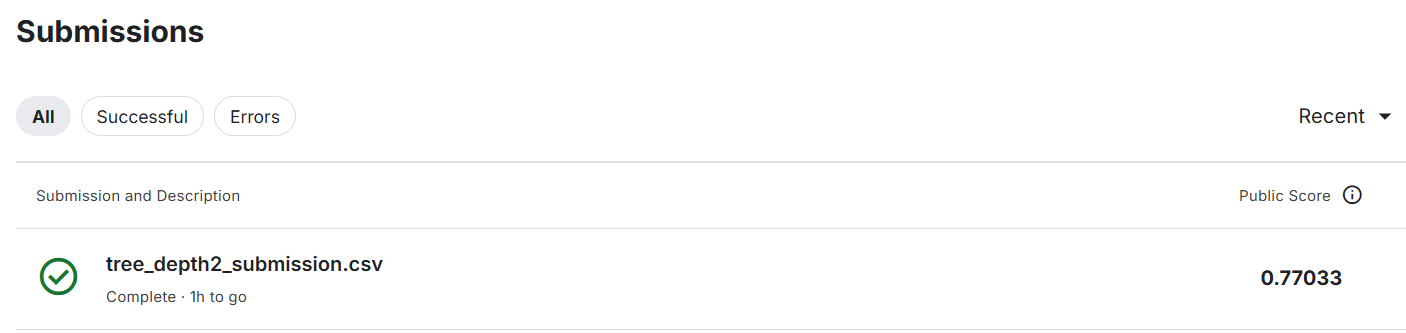

In [25]:
from IPython.display import Image
Image(filename="D:\Bakhyt\depth2.png")

Загрузите его на Kaggle.

<font color='red'>Вопрос. </font> Каков результат первой посылки (дерево решений без настройки параметров) в публичном рейтинге соревнования Titanic?

<font color='red'>Ответ: </font>

In [26]:
0.77

0.77

## 3. Визуализация дерева решений (10%)

Визуализируйте полученное дерево при помощи `export_graphviz`.

In [27]:
!pip install graphviz


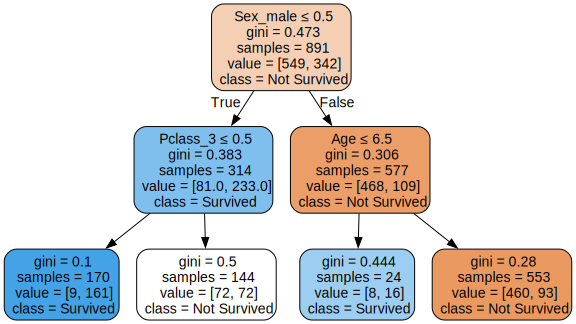

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=train_df.columns,  
                           class_names=["Not Survived", "Survived"],  
                           filled=True, rounded=True, special_characters=True)  

graph = graphviz.Source(dot_data)  
graph.render("decision_tree")
graph 


<font color='red'>Вопрос. </font> Какие признаки и пороги задействованы в дереве?

In [35]:
# Пол, Pclass и возраст. Порог возраста для мужчин: 6,5

<font color='red'>Ответ: </font>

## 4. Дерево решений с настройкой параметров (30%)

Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Также укажите `random_state=17`. Поэкспериментируейте с максимальной глубиной и минимальным числом элементов в листе

In [36]:
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, random_state=17)  
tree.fit(train_df, y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, random_state=17)

Оцените качество классификации на кросс-валидации с помощью функции`cross_val_score` или на отложенной выборке с помощью функции `train_test_split`?

In [38]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(tree, train_df, y, cv=5, scoring="accuracy")

print(f"Средняя accuracy на кросс-валидации: {cv_scores.mean():.4f}")


Средняя accuracy на кросс-валидации: 0.8036


Какой получилась средняя доля верных ответов (`accuracy_score`) на для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_leaf": [1, 3, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid, cv=5, scoring="accuracy")
grid_search.fit(train_df, y)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая средняя точность: {grid_search.best_score_:.4f}")


Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 5}
Лучшая средняя точность: 0.8238


Сделайте предсказание на тестовой выборке и сделайте submit в kaggle.

In [42]:
best_tree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, random_state=17)
best_tree.fit(train_df, y) 
test_predictions2 = best_tree.predict(test_df)
save_submission(test_predictions2, range(892,1310), "tree_depth7_leaf5_submission.csv")

Приложите screenshot submit в Kaggle на публичном Leaderboard

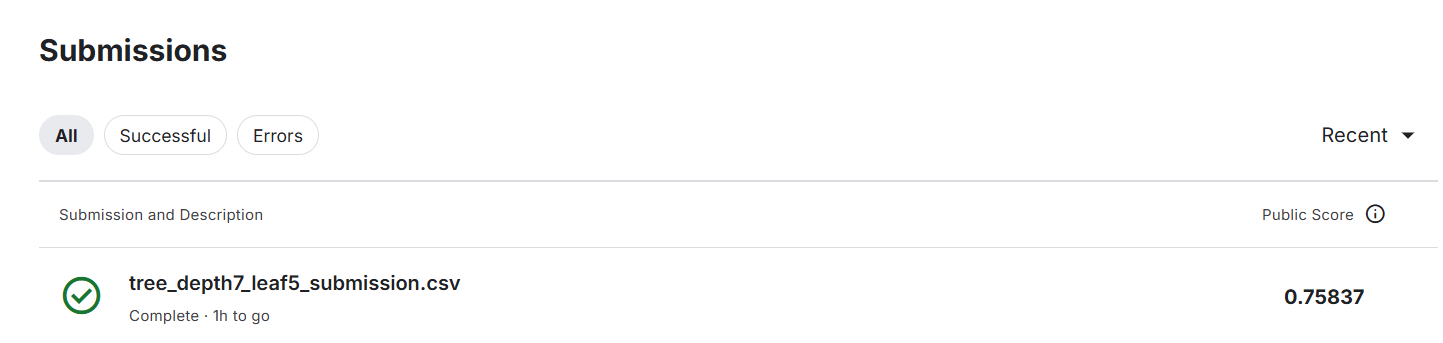

In [43]:
from IPython.display import Image
Image(filename="D:\Bakhyt\myownparams.png")

<font color='red'>Вопрос. </font> Каков результат второй посылки (дерево решений с настройкой гиперпараметров) в публичном рейтинге соревнования Titanic?

In [ ]:
0.75

<font color='red'>Ответ: </font>

## 5. Визуализация дерева решений (10%)

Визуализируйте полученное дерево при помощи `export_graphviz`.

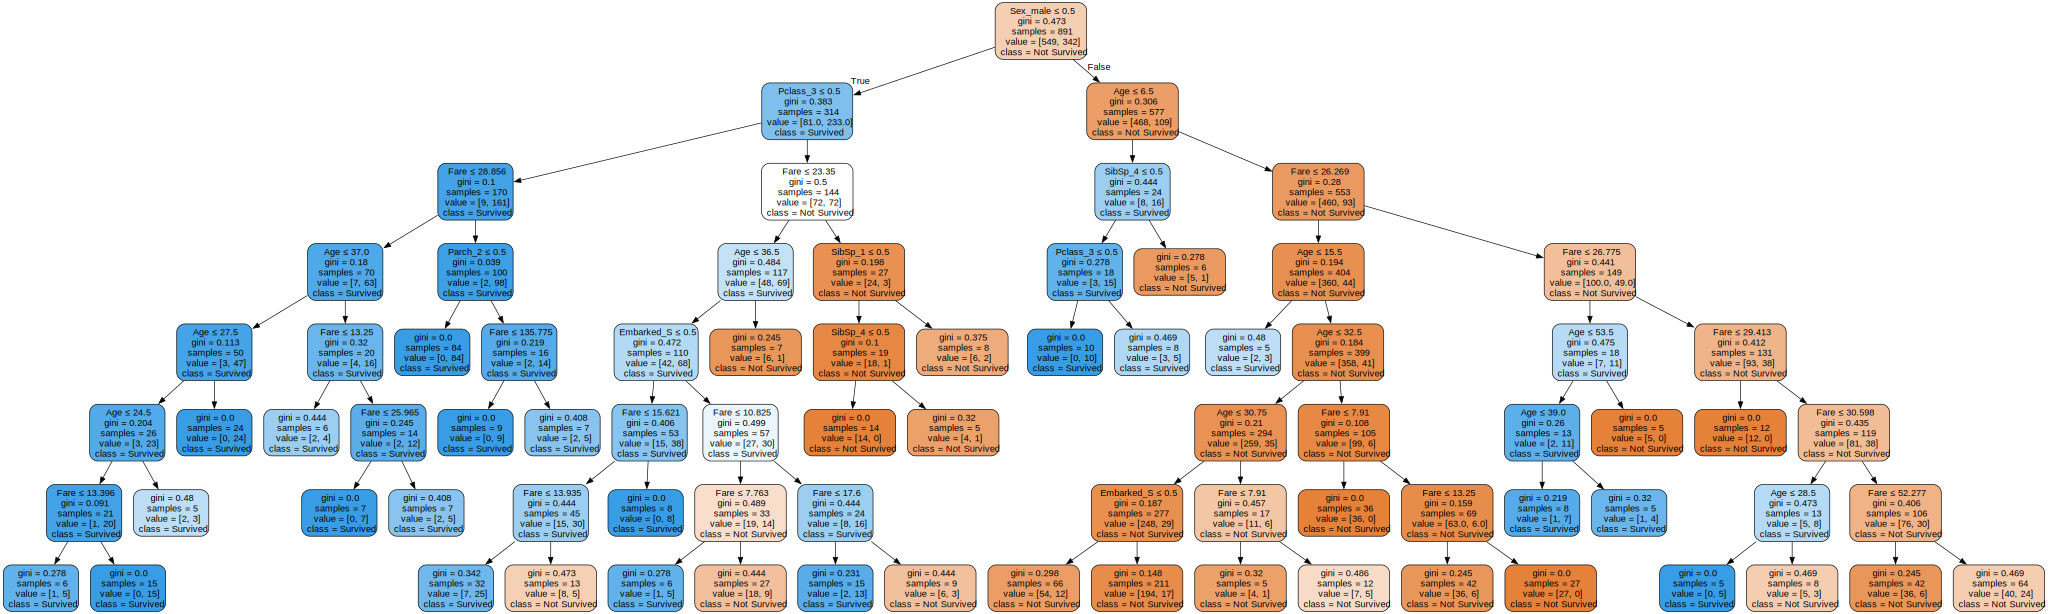

In [44]:
dot_data = export_graphviz(best_tree, out_file=None, 
                           feature_names=train_df.columns,  
                           class_names=["Not Survived", "Survived"],  
                           filled=True, rounded=True, special_characters=True)  

graph = graphviz.Source(dot_data)  
graph.render("decision_tree")
graph 

<font color='red'>Вопрос. </font> Какие признаки и пороги задействованы в дереве?

In [ ]:
#Пол, класс, возраст, стоимость билета, число сиблингов, порт посадки

<font color='red'>Ответ: </font>

# Сделали домашку?
Не забудьте оставить [Фидбек](https://forms.gle/GnuG1EpcgQd1wRdV7)